In [24]:
from argosim import antenna_utils  
from argosim import imaging_utils  
from argosim import metrics_utils  
from argosim import plot_utils  
from argosim import data_utils  

import numpy as np
import matplotlib.pyplot as plt

# sky model


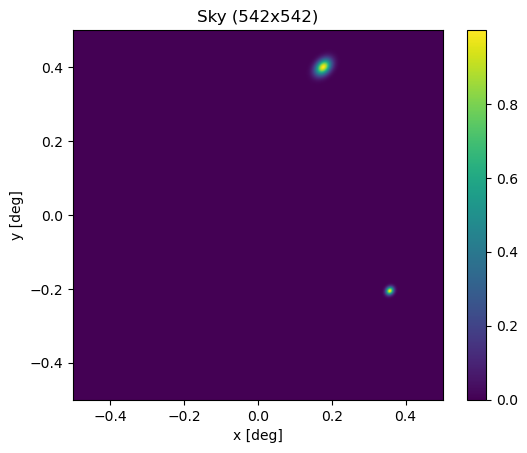

In [228]:
# Create the sky model using argosim.data_utils.n_source_sky()
im_size = (542,542)
fov = 0.3 # degrees
fov_size = (fov, fov)
sky_model = data_utils.n_source_sky(im_size, fov, [0.01, 0.005], [1., 1.])

# Plot the sky model
plot_utils.plot_sky(sky_model)


# Circular antenna configuration 

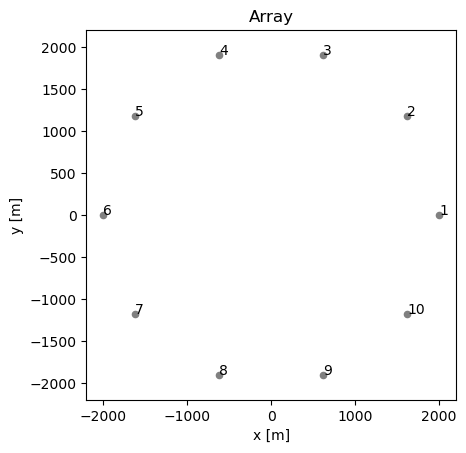

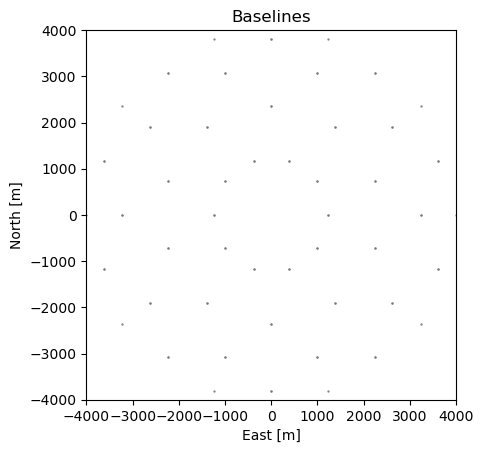

In [309]:
from argosim import antenna_utils 

circular_array = antenna_utils.circular_antenna_arr(n_antenna=10, r=2000)

plot_utils.plot_antenna_arr(circular_array)

# Compute the baselines and the uv-tracks.
baselines= antenna_utils.get_baselines(circular_array)

# Plot the baselines.
plot_utils.plot_baselines(baselines, ENU=True) 



# Uniform array

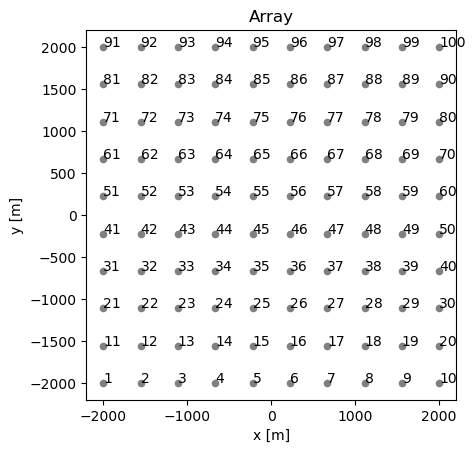

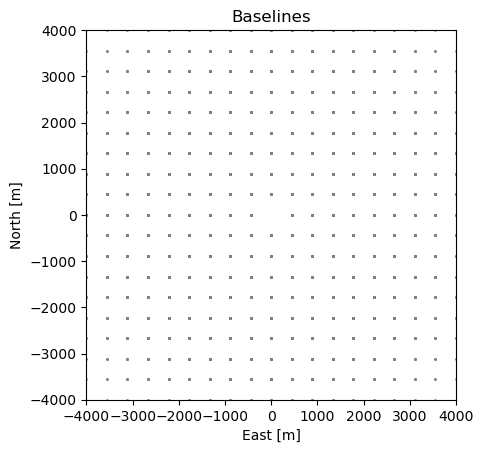

In [348]:
from argosim import antenna_utils 

uniform_array = antenna_utils.uni_antenna_array(n_antenna_E=10, n_antenna_N=10, E_lim=4000,N_lim=4000)

plot_utils.plot_antenna_arr(uniform_array)

# Compute the baselines and the uv-tracks.
baselines= antenna_utils.get_baselines(uniform_array)

# Plot the baselines.
plot_utils.plot_baselines(baselines, ENU=True) 


# Y array

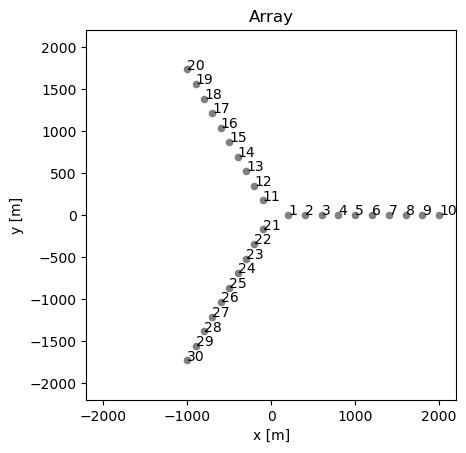

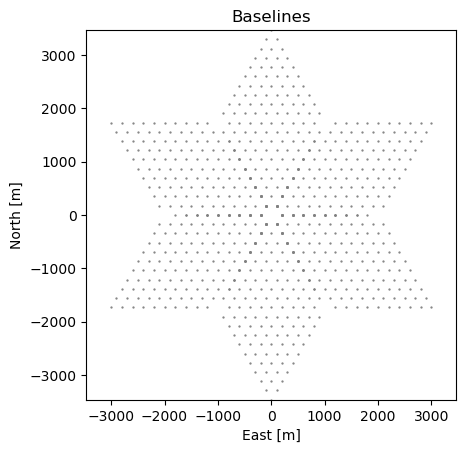

In [392]:
from argosim import antenna_utils 

y_array = antenna_utils.y_antenna_arr(n_antenna=10, r=2000, alpha=0)

plot_utils.plot_antenna_arr(y_array)

# Compute the baselines and the uv-tracks.
baselines= antenna_utils.get_baselines(y_array)

# Plot the baselines.
plot_utils.plot_baselines(baselines, ENU=True) 

# Combination array

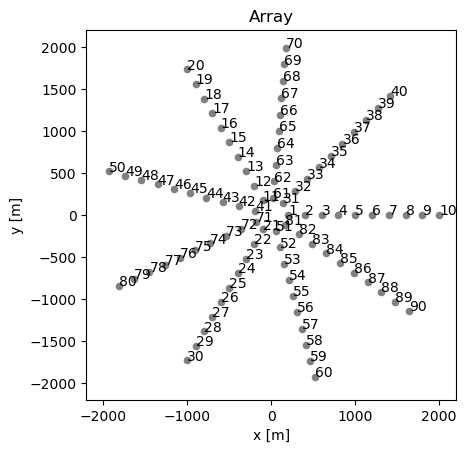

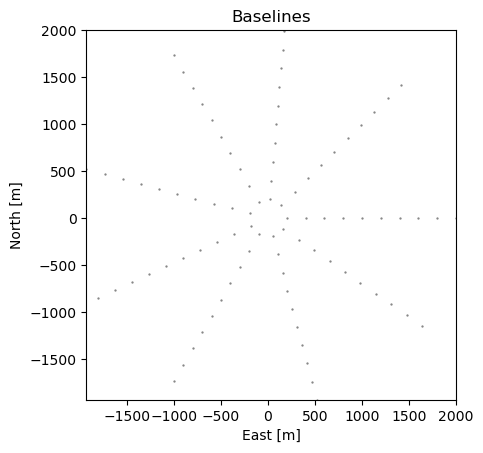

In [402]:
y_array1 = antenna_utils.y_antenna_arr(n_antenna=10, r=2000, alpha=45)
y_array2 = antenna_utils.y_antenna_arr(n_antenna=10, r=2000, alpha=85)


combined_array= antenna_utils.combine_antenna_arr(y_array,y_array1)
combined_array_2=antenna_utils.combine_antenna_arr(combined_array,y_array2)
plot_utils.plot_antenna_arr(combined_array_2)

# Compute the baselines and the uv-tracks.
baselines= antenna_utils.get_baselines(combined_array_2)

# Plot the baselines.
plot_utils.plot_baselines(combined_array_2, ENU=True) 

# uv- tracks

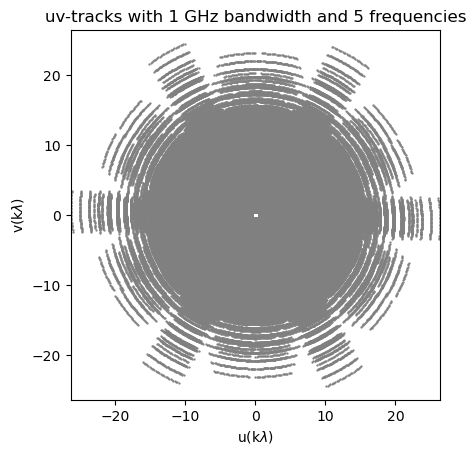

In [394]:
# Compute the uv-sampling tracks for the following parameters:


latitude= np.deg2rad(58)    
source_declination = np.deg2rad(58)  

track_time = 1  # in hours 
t_0 = 0    
n_times = 30        #60/2 = 30 (every 2min for 60min)
freq = 1.5e9
bandwidth = 1e9 
df= bandwidth
n_freqs = 5

# Compute the uv-tracks

uv_tracks = antenna_utils.uv_track_multiband(baselines, lat=latitude, dec=source_declination, track_time=track_time, t_0=t_0, n_times=n_times, f=freq, df=df,n_freqs=n_freqs, multi_band=False)[0]

# Plot the baselines and the uv-tracks using the plot_utlis module.

plot_utils.plot_baselines(uv_tracks,ENU=False)
plt.title("uv-tracks with 1 GHz bandwidth and 5 frequencies")
plt.show()


# Dirty image & Dirty beam 


Text(0.5, 1.0, 'Dirty Beam')

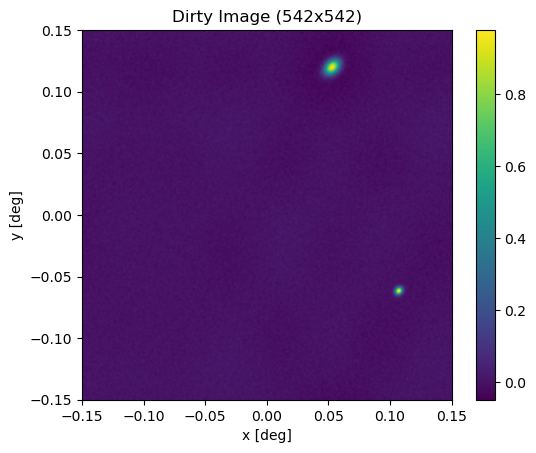

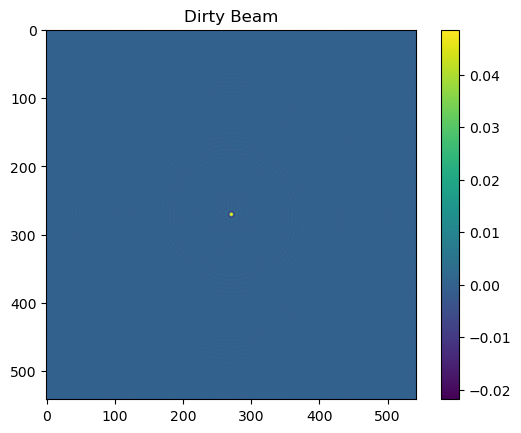

In [403]:
# Get the dirty image 

obs, dirty_beam = imaging_utils.simulate_dirty_observation(sky_model, uv_tracks, fov, sigma=0.02)

# Plot the dirty image and the beam
plot_utils.plot_sky(obs, fov_size=(fov, fov), title="Dirty Image")

dirty_beam_shifted = np.fft.fftshift(dirty_beam)
plot_utils.plot_beam(dirty_beam_shifted)

plt.title('Dirty Beam')

# Cleaning image 

Text(0.5, 1.0, 'cleaned image')

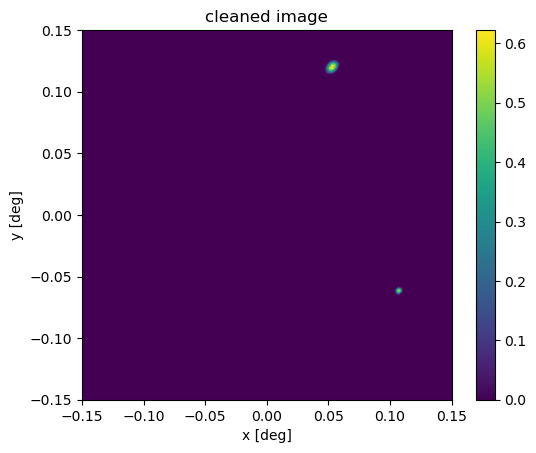

In [404]:
from argosim.clean import *

I_clean, sky__model = clean_hogbom(obs, dirty_beam, gamma=0.2, 
                                   max_iter=100, threshold=1e-3 , 
                                   clean_beam_size_px=3, res=False)

# Plot the clean image
plot_utils.plot_sky(I_clean, fov_size)
plt.title('cleaned image')

# Metric 


metric: {'mse': np.float64(0.0003268482973503078), 'residual': array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.00128664e-106, 1.15839858e-107, 6.58438115e-109],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.16520015e-106, 1.26063874e-107, 7.20761338e-109],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.30099505e-106, 1.34757259e-107, 7.74991406e-109]],
      shape=(542, 542))}
MSE: 0.000326848297350
MSE (manual): 0.000326848297350
True


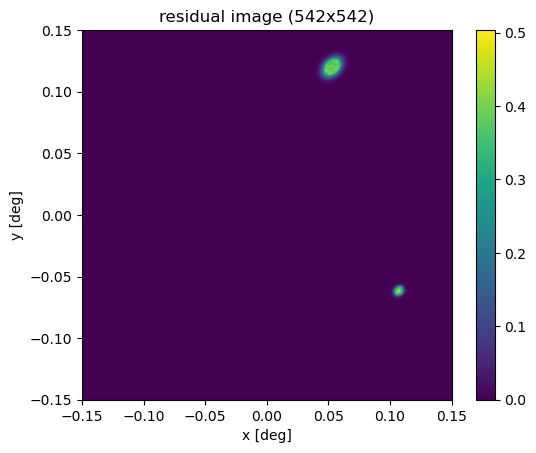

In [405]:
from argosim.metrics_utils import *


# compute the metrics

metrics = metrics_utils.compute_metrics(I_clean, sky_model)
print("metric:", metrics)


# Plot the residual and check the mse

residual_image = metrics_utils.residual(I_clean, sky_model, True)
plot_utils.plot_sky(residual_image, fov_size=fov_size, title="residual image")

mse_value=metrics_utils.mse(I_clean, sky_model)
print(f"MSE: {mse_value:.15f}")

# Verify that the mse is the mean of the squared residuals

mse_manual = np.mean(residual_image ** 2)

print(f"MSE (manual): {mse_manual:.15f}")

#checking the equality between the two values

assert np.isclose(mse_value, mse_manual), "False"

print("True")


In [495]:
import numpy as np

def are_local_neighborhoods_equal(img1, img2, window_size=3, threshold=1e-6):
    """
    Compare les voisinages locaux entre deux images.

    Paramètres :
    - img1, img2 : les deux images à comparer (numpy arrays 2D)
    - window_size : taille du voisinage carré (doit être impair, ex: 3, 5)
    - threshold : tolérance sur la différence (pour compenser les petites erreurs numériques)

    Retourne :
    - True si tous les voisinages sont similaires, False sinon
    """
    if img1.shape != img2.shape:
        raise ValueError("Les deux images doivent avoir la même taille.")
    
    h, w = img1.shape
    r = window_size // 2

    for i in range(r, h - r):
        for j in range(r, w - r):
            neighborhood1 = img1[i - r:i + r + 1, j - r:j + r + 1]
            neighborhood2 = img2[i - r:i + r + 1, j - r:j + r + 1]
            
            diff = np.abs(neighborhood1 - neighborhood2)
            if np.sum(diff) > threshold:
                print(f"Différence détectée au pixel ({i}, {j})")
                return False
    
    return True
equal = are_local_neighborhoods_equal(sky_model, I_clean, window_size=5, threshold=1e-3)

if equal:
    print("✅ Les voisinages locaux sont similaires partout.")
else:
    print("❌ Des différences locales ont été détectées entre les deux images.")



Différence détectée au pixel (52, 128)
❌ Des différences locales ont été détectées entre les deux images.


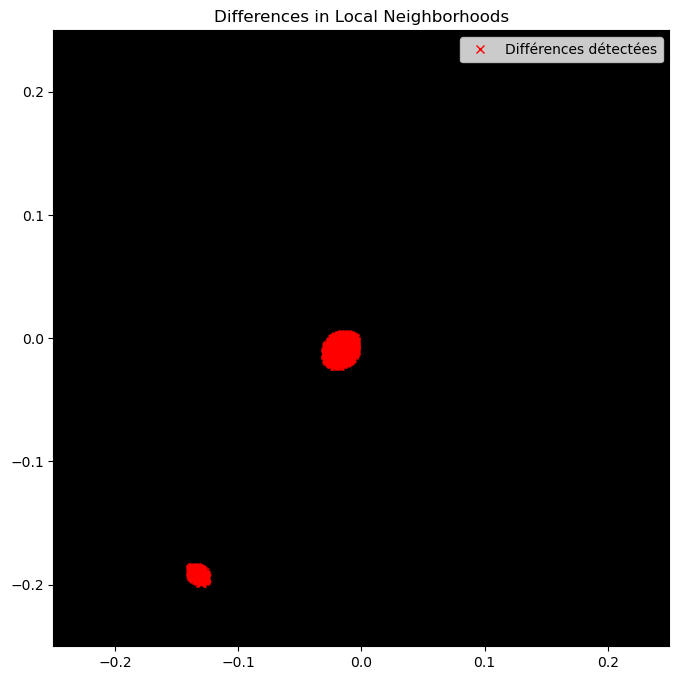

Score de fidélité CLEAN : 0.997


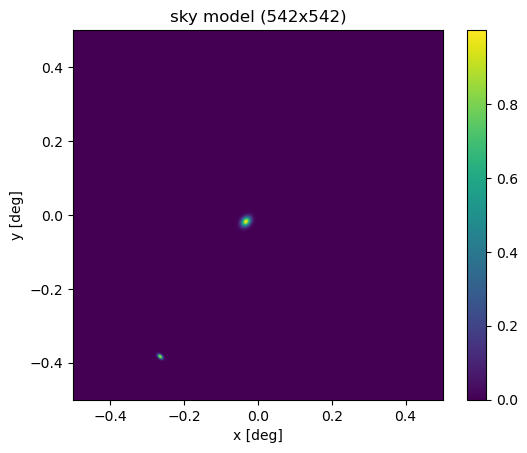

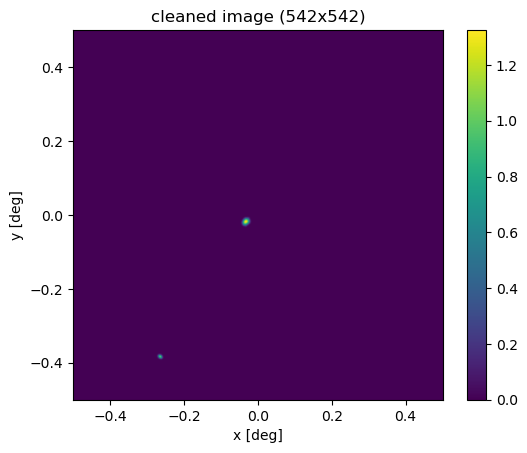

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_different_neighborhoods(img1, img2, window_size=3, threshold=1e-6):
    """
    Compare les voisinages entre deux images et retourne les coordonnées où ils diffèrent.
    
    Retourne une liste de tuples (i, j) où les voisinages diffèrent.
    """
    if img1.shape != img2.shape:
        raise ValueError("Les deux images doivent avoir la même taille.")
    
    h, w = img1.shape
    r = window_size // 2
    different_points = []

    for i in range(r, h - r):
        for j in range(r, w - r):
            neighborhood1 = img1[i - r:i + r + 1, j - r:j + r + 1]
            neighborhood2 = img2[i - r:i + r + 1, j - r:j + r + 1]
            
            diff = np.abs(neighborhood1 - neighborhood2)
            if np.sum(diff) > threshold:
                different_points.append((i, j))
    
    return different_points


def plot_differences_on_obs(obs, points, fov_size=(1.0, 1.0), title="Differences in Local Neighborhoods"):
    """
    Affiche l'image obs avec des croix rouges sur les pixels où les voisinages diffèrent.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Afficher l'image avec plot_utils (si tu veux utiliser plot_utils)
    # plot_utils.plot_sky(obs, fov_size=fov_size, ax=ax, title=title)

    # Sinon, matplotlib direct pour contrôle total :
    extent = [-fov_size[0]/2, fov_size[0]/2, -fov_size[1]/2, fov_size[1]/2]
    ax.imshow(obs, cmap='gray', extent=extent, origin='lower')
    ax.set_title(title)

    # Ajouter les croix rouges
    if points:
        xs = [j / obs.shape[1] * fov_size[0] - fov_size[0]/2 for (_, j) in points]
        ys = [i / obs.shape[0] * fov_size[1] - fov_size[1]/2 for (i, _) in points]
        ax.plot(xs, ys, 'rx', markersize=6, label='Différences détectées')
        ax.legend()

    plt.show()

I_clean, sky__model = clean_hogbom(obs, dirty_beam, gamma=0.2, 
                                   max_iter=100, threshold=1e-3 , 
                                   clean_beam_size_px=3, res=False)

# Paramètres
window = 2
threshold = 0.1

# Trouver les points où les voisinages diffèrent
differences = find_different_neighborhoods(sky_model, I_clean, window_size=window, threshold=threshold)

# Afficher l'image obs avec des croix aux endroits différents
plot_differences_on_obs(I_clean, differences, fov_size=(fov, fov))
plot_utils.plot_sky(sky_model, title="sky model")
plot_utils.plot_sky(I_clean, title="cleaned image")



# Local Neighborhood Accuracy

In [ ]:
def compute_local_neighborhood_score(img1, img2, window_size=3, threshold=1e-3):
    """
    Calcule le pourcentage de voisinages identiques entre deux images.
    Retourne : (score entre 0 et 1, nb_total, nb_différents)
    """
    h, w = img1.shape
    r = window_size // 2
    total = 0
    different = 0

    for i in range(r, h - r):
        for j in range(r, w - r):
            patch1 = img1[i - r:i + r + 1, j - r:j + r + 1]
            patch2 = img2[i - r:i + r + 1, j - r:j + r + 1]
            diff = np.sum(np.abs(patch1 - patch2))

            total += 1
            if diff > threshold:
                different += 1

    score = 1 - (different / total)
    return score, total, different
score, total, diff = compute_local_neighborhood_score(sky_model, I_clean, window_size=5, threshold=0.1)

print(f"🔍 Score de fidélité CLEAN (voisinages) : {score:.3f}")
print(f"→ {diff} différences sur {total} voisinages comparés")



🔍 Score de fidélité CLEAN (voisinages) : 0.996
→ 1021 différences sur 289444 voisinages comparés
